# Torneo de los 30

Partiendo de un archivo *.csv* con los resultados de los partidos del torneo, por fecha, hacemos un par de transformaciones y cálculos para obtener algunos gráficos y estadísticas del ya finalizado torneo argentino de fútbol.

Sirve además como excusa par experimentar con Pandas, matplotlib y Jupyter!

In [1]:
# imports iniciales
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# queremos que los gráficos se rendericen inline
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# configuración para los gráficos, estilo y dimensiones
matplotlib.style.use('ggplot')
figsize(12, 12)

### Leemos los datos del archivo .csv

In [4]:
# levantamos los datos del archivo en un DataFrame de Pandas
data = pd.read_csv('data/resultados.csv')

In [5]:
# una muestra de los datos que tenemos disponibles: una fila por cada partido, agrupados por fecha
data.head()

,fecha,local,gl,visitante,gv,arbitro,timestamp
0,1,Argentinos Juniors,2,Atletico Rafaela,0,Pablo Lunati,2015-02-15 19:10:00
1,1,Arsenal de Sarandí,0,Estudiantes La Plata,1,Darío Herrera,2015-02-16 18:00:00
2,1,Banfield,0,Temperley,1,Silvio Trucco,2015-02-14 20:30:00
3,1,Belgrano,3,Nueva Chicago,1,Mariano González,2015-02-16 21:10:00
4,1,Boca Juniors,3,Olimpo,1,Fernando Echenique,2015-02-15 18:15:00


### Precalculamos información útil

Vamos a extender nuestros datos con información adicional.

En este caso vamos a agregar columnas extras indicando si el resultado del partido fue para el local ('L'), para el visitante ('V') o empate ('E'), y por otro lado, una columna con el total de goles por partido.

In [6]:
data['L'], data['E'], data['V'] = data.gl > data.gv, data.gl == data.gv, data.gl < data.gv

In [7]:
data['goles'] = data.gl + data.gv

## Distribución de los resultados

A partir de los resultados de los partidos vamos a generar un gráfico que refleje qué resultados y cuántos de cada uno se dieron a lo largo del torneo.

In [8]:
# nos quedamos con las columnas de goles local y goles visitante (ie. los resultados)
goles = data[['gl', 'gv']]

In [9]:
# agrupamos los resultados para quedarnos con una ocurrencia de cada combinación y los contamos
resultados = goles.groupby(['gl', 'gv'])
num_resultados = resultados.size()

In [10]:
# separamos resultados y su cantidad, y también los goles, para generar el gráfico
uniq_resultados, counts = zip(*num_resultados.iteritems())
goles_local, goles_visitante = zip(*uniq_resultados)

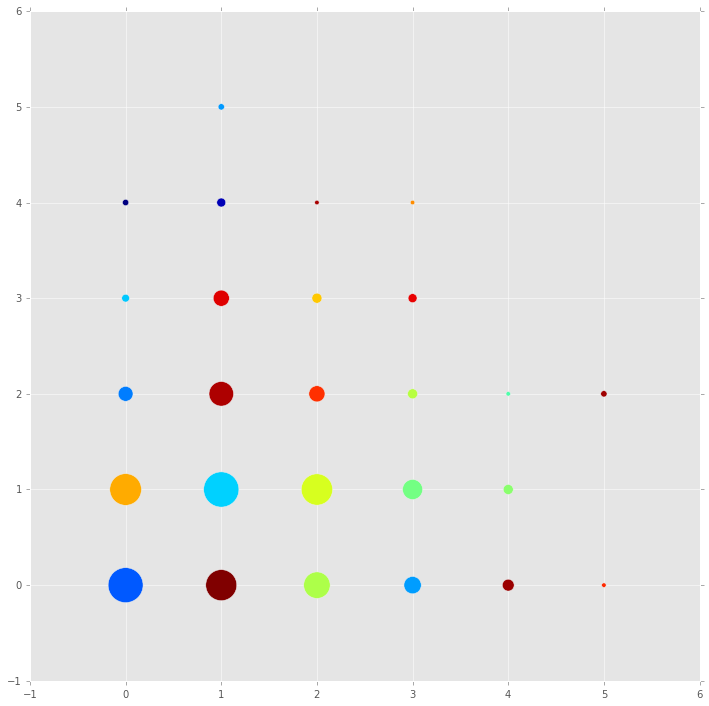

In [11]:
plt.scatter(goles_local, goles_visitante, s=list(map(lambda i: i*20, counts)), c=np.random.rand(len(counts)))

## Distribución de Local/Empate/Visitante por fecha

Para cada fecha, cantidad de Local/Empate/Visitante.

In [12]:
# nos quedamos con las columnas que nos interesan, agrupamos por fecha, y contamos
por_fecha = data[['fecha', 'L', 'E', 'V']].groupby(['fecha']).agg(np.count_nonzero)

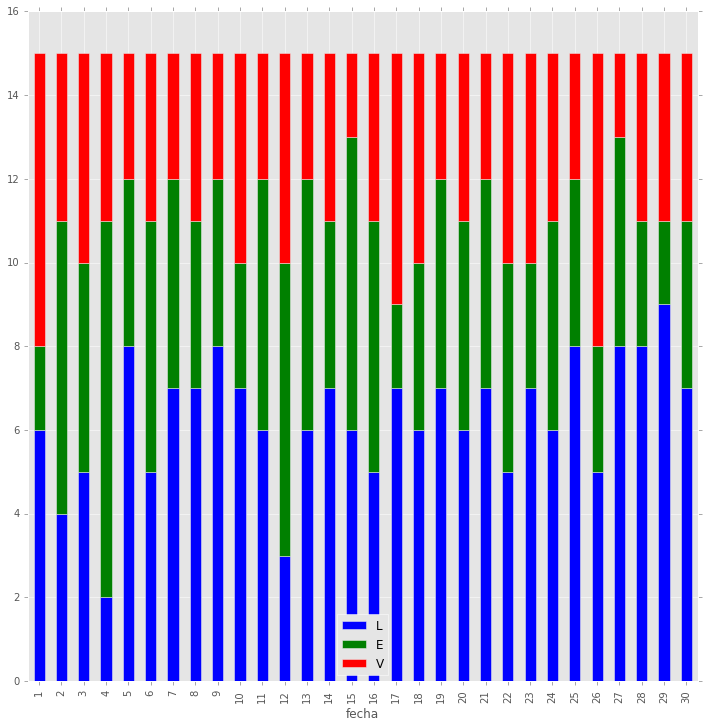

In [13]:
por_fecha.plot(kind='bar', stacked=True)

## Cantidad de goles por fecha

Cuál fue la fecha con más goles? La de menor cantidad?

In [14]:
# nos quedamos con las columnas que nos interesan, agrupamos y sumamos los goles por fecha
goles_por_fecha = data[['fecha', 'goles']].groupby(['fecha']).agg(np.sum)
# además calculamos la media
promedio_por_fecha = int(goles_por_fecha.mean())

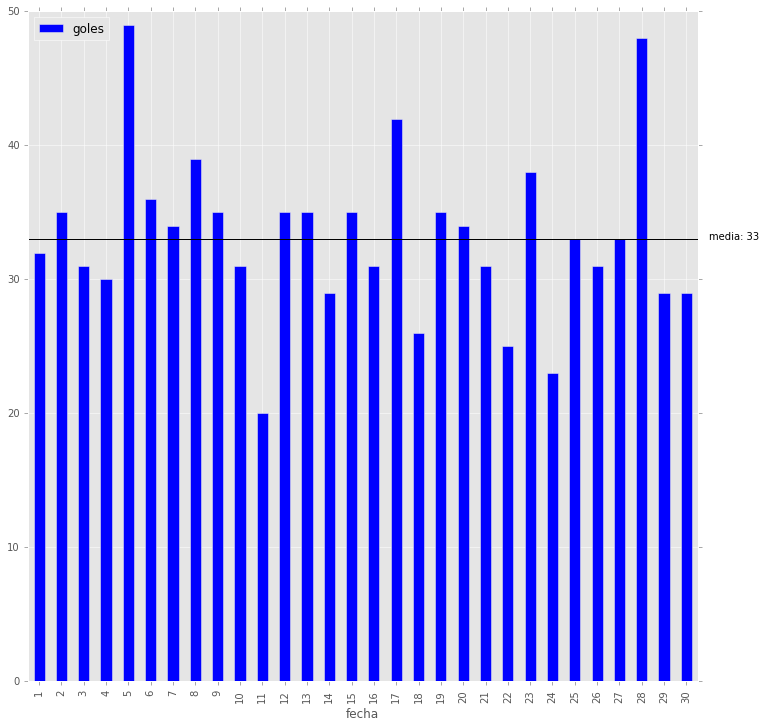

In [15]:
goles_por_fecha.plot(kind='bar')
plt.axhline(promedio_por_fecha, color='k')
plt.text(30, promedio_por_fecha, 'media: %d' % promedio_por_fecha)

## Evolución de los equipos

Vamos a graficar cómo fueron progresando los equipos (en este caso el Top 5 final) a lo largo del torneo.

In [16]:
# nombres de los equipos
equipos = data.local.unique()

In [17]:
# función para calcular los puntos obtenidos por un equipo en un partido dado
func_puntos = lambda team, match: 3 if ((match['local'] == team and match['L']) or (match['visitante'] == team and match['V'])) else (1 if match['E'] else 0)

In [18]:
# puntaje total por equipo
final = {}

# puntos por fecha por equipo
fechas = pd.DataFrame(data.fecha.unique(), columns=['fecha'])
for equipo in equipos:
    partidos_por_equipo = data[(data.local == equipo) | (data.visitante == equipo)]
    puntos = partidos_por_equipo.apply(lambda row: func_puntos(equipo, row), axis=1)
    partidos_por_equipo[equipo] = puntos.cumsum()
    fechas = fechas.merge(partidos_por_equipo[['fecha', equipo]], on='fecha')
    # guardamos el total
    final[equipo] = puntos.sum()

In [19]:
# posiciones finales del torneo
posiciones = sorted(final.items(), key=lambda i: i[1], reverse=True)

In [20]:
posiciones[:10]

[('Boca Juniors', 64),
 ('San Lorenzo', 61),
 ('Rosario Central', 59),
 ('Racing Club', 57),
 ('Independiente', 54),
 ('Estudiantes La Plata', 51),
 ('Belgrano', 51),
 ('Banfield', 50),
 ('River Plate', 49),
 ('Tigre', 46)]

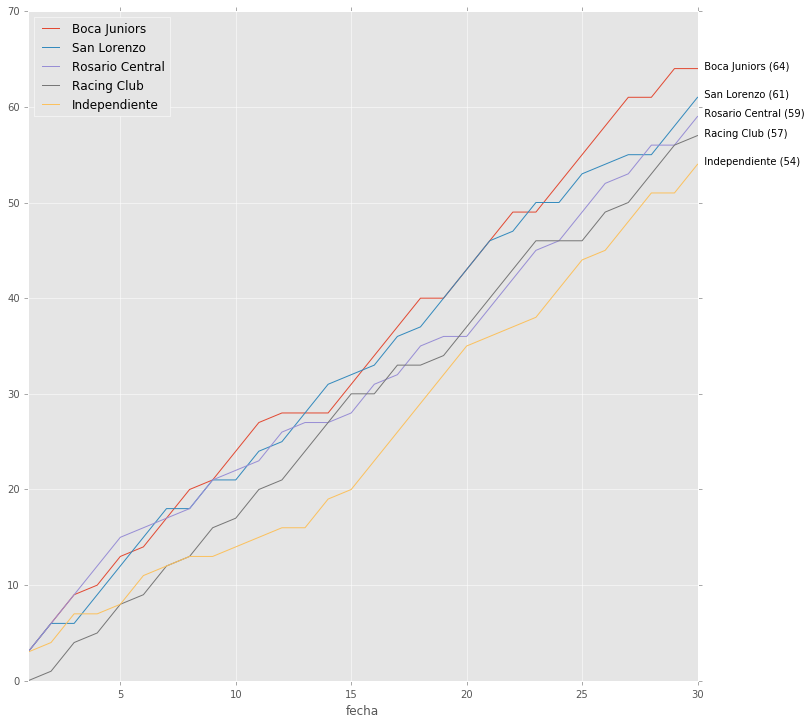

In [21]:
N = 5
# nos quedamos con los primeros N equipos en las posiciones finales
top_n = [e for e, pts in posiciones[:N]]
# graficamos la evolución fecha a fecha para esos equipos
fechas[['fecha'] + top_n].plot(x='fecha')
for e, pts in posiciones[:N]:
    plt.text(30, pts, '  %s (%d)' % (e, pts))